
# News Data Reliability Analysis Overview

## Introduction

This notebook presents a comprehensive analysis of news articles collected as part of the **AI4Trust** platform, focusing on the reliability of news sources over time. The goal is to quantify the daily number of news items originating from **reliable** vs **unreliable** sources within a given date range, and to further break down these counts by language, source country, and topic. By the end of the notebook, we produce clear visualizations (diverging bar charts) that highlight trends in news reliability and allow comparisons across different categories.

## Data Input and Setup

**Data Sources:** The analysis connects to a Trino SQL database to retrieve news article metadata from a target table (here named `collected_news`). It also loads an external dataset of domain reliability scores (from prior research by Lin, Lasser et al. [1]) which provides a reliability rating for each news domain on a scale from 0 (low quality) to 1 (high quality).

**Input Parameters:** The primary input to the notebook is a **date range** (a start date and end date) that defines the time window of interest for analysis. In this case, the window is set from **2025-03-01** to **2025-07-27**. These dates can be adjusted as needed to analyze different periods. Additionally, database connection settings (host, port, user, catalog, schema) are read from environment variables or defaults, allowing the notebook to connect to the correct data source.

**Setup:** After importing necessary libraries (for data handling, visualization, etc.), the notebook establishes a connection to the Trino database. It automatically detects which schema contains the `collected_news` table (unless a specific schema is provided) and prepares an SQLAlchemy engine for executing queries. Once connected, the notebook retrieves all relevant columns for news articles within the chosen catalog and schema. At this stage, the **output** is a Pandas DataFrame (`df_raw`) containing all news articles (and their attributes like URL, publication date, language, topic, etc.) available in the specified date range (or the entire dataset if no range filter is applied yet).

[1]. Lin H, Lasser J, Lewandowsky S, et al. (2023) High level of correspondence across different news domain quality rating sets. PNAS Nexus 2:pgad286.


## Data Preparation and Filtering

Before analysis, the raw data undergoes cleaning and filtering steps to ensure consistency:

* **Date Parsing:** The article timestamps are parsed and standardized. Each article has a `publish_date` (when the news was published) and a `created_at` (when it was collected). The code converts these to timezone-naive `datetime` objects. If an article’s `publish_date` is missing, it falls back to using the `created_at` timestamp. This ensures every article has a valid date.

* **Date Range Filtering:** The data is filtered to include only articles published in or after the year 2025. Then, it is further restricted to the specified analysis window (from **2025-03-01** up to **2025-07-27**, inclusive). Articles outside this period are excluded from further analysis. The **input** to this step is the DataFrame of raw articles and the chosen start/end dates; the **output** is a filtered DataFrame (`df_window`) containing only articles in the desired time window.

* **Deduplication:** Within the time window, duplicate articles (identified by the same `url`) are removed to avoid double-counting the same news item. Only the first occurrence of each URL is kept. After this step, we have a clean set of unique news articles for the time window of interest, sorted chronologically by publication date.

By the end of data preparation, the notebook has a cleaned DataFrame of **daily news articles** in the given period, ready for reliability analysis. The key fields retained include the article’s publication date (normalized to date-only precision for daily grouping), language, topic category, source domain, and source country.

## Reliability Scoring and Categorization

Each news article is then assessed for source reliability using a precomputed domain reliability score. These scores come from an external dataset (e.g. the composite **PC1 reliability rating** for news domains from Lin, Lasser et al.), where each domain is assigned a quality/reliability score between 0.0 and 1.0. Higher scores indicate that the domain is generally reputable (reliable), while lower scores indicate a questionable or low-quality source. The notebook performs the following:

* **Score Mapping:** For each article, the source domain is looked up in the reliability score table. The score (if available) is added to the article’s data under a new column (e.g. `reliability`). Articles whose domain is not found in the score table are left with `NaN` (treated as unknown reliability).

* **Threshold-Based Classification:** Using defined threshold values, the continuous reliability score is converted into categorical labels:

  * If a domain’s reliability score is **above 0.6**, the article is labeled as **“reliable”** (high reliability source).
  * If the score is **below 0.4**, the article is labeled as **“unreliable”** (low reliability source).
  * Scores in the intermediate range \[0.4, 0.6] or missing scores are labeled as **“mid”** or **“not determined”**, indicating that the source’s reliability is not clearly established (could be moderate or unknown).

As a result, every article in the dataset is classified into one of three reliability categories: **reliable**, **unreliable**, or **not determined**. This categorical classification will allow counting and comparing articles by source trustworthiness.

## Aggregating News Counts and Saving Results

With each article tagged by date and reliability category (and carrying attributes like language, country, topic), the notebook aggregates the data to obtain daily counts. The aggregation is done in multiple ways to support different analyses and visualizations:

1. **Daily Total by Reliability:** The number of articles per day is tallied for each reliability category. For each date in the range, we compute:

   * *Reliable\_count*: how many articles published that day came from reliable sources.
   * *Unreliable\_count*: how many came from unreliable sources.
   * *Not\_determined*: how many came from sources in the mid/unknown category.

   These daily counts are combined into a table where each row is a date and the columns are the counts of each category for that date. This aggregated data is then saved as a JSON file (`news_article_counts_by_date_reliability.json`). The JSON structure contains the data (dates and counts) as well as some metadata (title and axis labels for plotting). The **output** of this step is the JSON file which can be used to drive a visualization of reliable vs unreliable news trends over time.

2. **Daily by Language and Reliability:** Here the data is grouped by date **and** article language, with separate counts for reliability categories. For each date, we count how many articles were reliable vs unreliable for each language appearing that day. This produces a multi-column table (with languages as columns). For example, one column might be “en\_reliable” (count of reliable English articles on that date) and another “en\_unreliable” (count of unreliable English articles), and similarly for other languages (fr, it, etc.). A separate category “not\_determined” is also calculated per language (though in visualization we focus on reliable/unreliable). This aggregated result is saved as `news_article_counts_by_language_reliability.json`. The **output** JSON contains daily counts of news items broken down by language and reliability status. It enables analysis of how different language news sources contribute to reliable vs unreliable content over time. (In practice, there may be many languages, so the notebook will later focus on the top languages by volume to keep plots readable, grouping the rest as "Other".)

3. **Daily by Source Country and Reliability:** Similarly, the data is grouped by date and the country of the news source. For each date, counts of reliable and unreliable articles are computed for each source country (e.g., US\_reliable, US\_unreliable, IT\_reliable, IT\_unreliable, etc.), with an analogous “not\_determined” category. The result is saved to `news_article_counts_by_country_reliability.json`. The **output** is a JSON file capturing how different countries’ news sources contribute to the daily reliable/unreliable totals. Again, the visualization will typically highlight the top source countries and aggregate others if needed.

4. **Daily by Topic and Reliability:** In this case, grouping is by date and the news topic/category (for example, Politics, Health, Sports, etc., as provided in the data). For each date, the number of reliable vs unreliable articles is counted for each topic. The result (e.g., columns like Politics\_reliable, Politics\_unreliable, …) is stored in `news_article_counts_by_topic_reliability.json`. This JSON output enables an analysis of which news topics have more reliable or unreliable coverage over time. Because there can be many distinct topics, the notebook will later focus on the top topics by volume (e.g., top 10) in the visualization, with the rest grouped as "Other".

By saving these aggregated datasets as JSON, the notebook facilitates easy reuse of the data for plotting or for external reporting. Each JSON contains both the raw counts and some descriptive fields (chart title, labels) to aid in downstream visualization. The **inputs** to these aggregation steps are the filtered DataFrame of articles with reliability categories, and the **outputs** are the four JSON files capturing daily counts by reliability overall and segmented by language, country, and topic.

## Visualization of Results

Using the aggregated data, the notebook produces several **visualizations** to illustrate the trends in news reliability. All visualizations use a **diverging bar chart** format, where counts of reliable sources are shown as positive (upwards bars) and counts of unreliable sources are shown as negative (downwards bars) for each day. This format makes it easy to see the “balance” of reliable vs unreliable news on any given day. A horizontal baseline at zero (marked in yellow on the plots) separates the reliable and unreliable portions, and a black dashed line is plotted to indicate the net difference (Reliable minus Unreliable) each day. By excluding or separately marking the "not determined" category, the charts focus on the clear contrast between reliable and unreliable sources. Below we describe each visualization and its inputs/outputs in detail:

* **Daily Reliability Divergence Plot:** *Input:* the daily reliability counts from `news_article_counts_by_date_reliability.json`. *Output:* a bar chart showing, for each date in the analysis window, the number of articles from reliable sources (upwards green bars) versus the number from unreliable sources (downwards red bars). The bar heights thus diverge from the center: for example, if on a certain day 50 reliable-source articles and 30 unreliable-source articles were collected, the chart shows +50 and –30 on that day. A dashed line connects the net difference across days, helping to visualize whether reliable news outweighed unreliable news (above the baseline) or vice versa. This plot provides an at-a-glance view of how the volume of trustworthy news compares to misinformation each day. (An option is noted in the code to include the "not determined" articles as a gray extension on the reliable side, but by default the plot highlights only definitively reliable vs unreliable totals for clarity.)

* **Language-wise Daily Reliability Trends:** *Input:* the language-segmented counts from `news_article_counts_by_language_reliability.json`. *Output:* a stacked diverging bar chart breaking down daily news counts by language of publication, split into reliable and unreliable portions. For each day, multiple bars are stacked above the baseline (each representing reliable news in a particular language) and similarly, bars stacked below the baseline (each representing unreliable news per language). The chart uses different colors for each language category. To maintain readability, the notebook automatically focuses on the top languages (by total article count in the period, e.g., top 5 languages) and aggregates all smaller languages into an "Other" category. This way, the plot clearly shows which languages contributed the most to reliable vs unreliable news each day. For example, one might observe that **English** articles form a large portion of both reliable and unreliable news, whereas **Italian** articles might be fewer and predominantly on the reliable side (hypothetically). The dashed line in this plot again shows the net reliable-minus-unreliable sum across all languages each day. Users can also modify the visualization (via the provided code template) to focus on a single language’s trend if desired, examining how that language’s reliable vs unreliable news balance changes over time.

* **Country-wise Daily Reliability Trends:** *Input:* the country-segmented counts from `news_article_counts_by_country_reliability.json`. *Output:* a similar stacked diverging bar chart, but with stacks representing source **countries** of the news articles. Each day’s reliable news is subdivided by country (e.g., US, UK, IT, etc. as separate colored segments above zero) and each day’s unreliable news likewise subdivided (segments below zero). The chart highlights which countries’ media are contributing more to reliable content and which are contributing to misinformation on a daily basis. As with languages, only the top source countries (e.g., top 5 by volume) are individually shown to avoid clutter, with all other countries grouped into an "Other" category. The net difference line indicates the overall daily balance of reliable vs unreliable news (summing across all countries). This visualization can reveal patterns such as certain countries producing a higher fraction of unreliable news relative to others, or synchronized surges of misinformation across countries on specific dates. Optionally, the code allows drilling down into a single country’s reliable/unreliable trend for closer inspection.

* **Topic-wise Daily Reliability Trends:** *Input:* the topic-segmented counts from `news_article_counts_by_topic_reliability.json`. *Output:* a stacked diverging bar chart where the daily bars are broken down by **news topic** (such as Politics, Health, Technology, etc.), again separated into reliable (above) and unreliable (below) contributions. The top topics by volume (for example, top 10 topics in the date range) are shown with distinct colors, and any remaining topics are grouped as "Other". This chart illustrates which news topics have a greater presence of unreliable sources versus reliable sources on each day. For instance, one might observe that on some days **Political** news had a significant unreliable portion (perhaps due to a particular misinformation event), whereas **Science** news might consistently come mostly from reliable sources. The difference line helps identify days where overall reliable coverage outpaced unreliable coverage (or vice versa) across all topics. The notebook’s code also provides a template to isolate a single topic’s trend if needed.

All these visualizations share a consistent format and labeling: the x-axis is the **Date** (within the selected range), and the y-axis is the **Number of news items** (with positive values indicating counts from reliable sources and negative values indicating counts from unreliable sources). The charts include legends (by reliability or by category) and concise titles (provided from the JSON metadata) to make them self-explanatory. By examining these plots, stakeholders can quickly grasp temporal dynamics in news reliability and identify patterns, such as spikes in unreliable news or differences in content quality across languages and countries.

## Validation of Aggregated Data

As a final step, the notebook performs an internal consistency check to ensure that the aggregation logic was correct. It compares the total number of articles in the filtered dataset to the sums of all categories in each of the aggregated results. Specifically, it verifies that:

* The total count of articles in the time window equals the sum of daily reliable + unreliable + not\_determined articles (from the daily JSON data).
* This total also matches the sum of all language-based counts, the sum of all country-based counts, and the sum of all topic-based counts.

This check confirms that no articles were lost or double-counted during grouping and that all the JSON outputs are accounting for the same set of articles. If any mismatch were found, the code would raise an assertion error, but upon successful execution, it prints a confirmation that **all totals match across daily, language, country, and topic aggregations**. This validation gives confidence that the input data and the derived visualizations are consistent and reliable.

## Conclusion

In summary, this notebook takes as **input** a collection of news articles with associated metadata (source, date, etc.) and a specified date range, and produces as **output** a series of JSON files and visual charts that illuminate the distribution of those news articles by source reliability over time. The analysis provides both high-level overviews (daily reliable vs unreliable trends) and detailed breakdowns (by language, country, topic), which can support researchers and stakeholders in understanding the landscape of information reliability. All steps are explained and carried out in a reproducible manner, making it straightforward to adjust the parameters (such as date window or reliability thresholds) or to integrate new data sources as needed for the AI4Trust platform’s ongoing monitoring of news media trustworthiness.


In [ ]:
# 1. Setup and Imports

In [ ]:
# Optional: Install necessary packages (if not already installed)
# !pip install "trino[sqlalchemy]==0.332.0" polars matplotlib pandas

import os
import re
import json
import datetime as dt
from pathlib import Path
from typing import Optional, Tuple

import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sqlalchemy.engine import create_engine


In [ ]:
# 2. Helper Functions for Parsing and I/O

In [ ]:
def _parse_host_port(host: Optional[str], port: Optional[str], default_port: int = 8080) -> Tuple[str, int]:
    """Parse host and port (with defaults and valid range checks)."""
    host = (host or "").strip()
    port = (port or "").strip()
    # Strip any scheme like http:// or tcp://
    host = re.sub(r"^(?:https?|tcp)://", "", host, flags=re.I)
    if ":" in host and not port:
        host, port = host.split(":", 1)
    try:
        port_int = int(re.sub(r"\D", "", port))
    except ValueError:
        port_int = default_port
    if not (1 <= port_int <= 65535):
        port_int = default_port
    return host or "localhost", port_int

def save_dict(d: dict, path: Path):
    """Save a dictionary as JSON to the given path (with date handling)."""
    def _json_default(value):
        if isinstance(value, (dt.datetime, dt.date)):
            return value.isoformat()
        return repr(value)
    path.write_text(json.dumps(d, default=_json_default))

def load_dict(path: Path) -> dict:
    """Load JSON data from a file into a Python dictionary."""
    return json.loads(path.read_text())

def df_from_data_d(data_d: dict) -> pl.DataFrame:
    """Recreate a Polars DataFrame from stored data, parsing 'date' to datetime."""
    return pl.DataFrame(data_d, schema_overrides={"date": pl.Datetime})

def _maybe_format_date_axis(ax, x_values):
    """
    If x_values look like datetime, format the x-axis with date labels to avoid clutter.
    Uses an AutoDateLocator for smart date tick spacing.
    """
    # Accept pandas Series, numpy array, or Polars Series
    if hasattr(x_values, "to_numpy"):
        x_array = x_values.to_numpy()
    else:
        x_array = np.array(x_values)
    if x_array.size == 0:
        return ax  # nothing to format
    first_elem = x_array[0]
    # Check if data is datetime-like
    if pd.api.types.is_datetime64_any_dtype(x_array) or isinstance(first_elem, (pd.Timestamp, np.datetime64)):
        locator = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.figure.autofmt_xdate()  # rotate labels for readability
    return ax


In [ ]:
# 3. Connect to Trino and Configure Schema

In [ ]:
# Read connection settings from environment (with defaults)
TRINO_HOST, TRINO_PORT = _parse_host_port(os.getenv("TRINO_HOST"), os.getenv("TRINO_PORT"))
TRINO_USER    = os.getenv("TRINO_USER",    "jupyter")
TRINO_CATALOG = os.getenv("TRINO_CATALOG", "iceberg")
TRINO_SCHEMA  = os.getenv("TRINO_SCHEMA")  # optional preferred schema

# print(f"🔌 Connecting to Trino at {TRINO_HOST}:{TRINO_PORT}, catalog='{TRINO_CATALOG}' "
#       f"(requested schema={TRINO_SCHEMA or 'auto-detect'})")

# Create SQLAlchemy engine for Trino
engine = create_engine(f"trino://{TRINO_USER}@{TRINO_HOST}:{TRINO_PORT}/{TRINO_CATALOG}")

TARGET_TABLE = "collected_news"

def find_schema_with_table(engine, catalog: str, table: str, preferred: Optional[str] = None) -> str:
    """Find which schema in the catalog contains the specified table (or use preferred)."""
    with engine.connect() as conn:
        schemas = pd.read_sql(f"SHOW SCHEMAS FROM {catalog}", conn)["Schema"].tolist()
        if preferred:
            if preferred not in schemas:
                raise ValueError(f"Schema '{preferred}' not found in catalog '{catalog}'. Available: {schemas}")
            tables = pd.read_sql(f"SHOW TABLES FROM {catalog}.{preferred}", conn)["Table"].tolist()
            if table not in tables:
                raise ValueError(f"Table '{table}' not found in schema '{preferred}'.")
            return preferred
        # If no preferred schema provided, search all schemas for the table
        for sch in schemas:
            tables = pd.read_sql(f"SHOW TABLES FROM {catalog}.{sch}", conn)["Table"].tolist()
            if table in tables:
                return sch
    raise ValueError(f"Table '{table}' not found in any schema of catalog '{catalog}'.")

# Determine active schema containing the target table
ACTIVE_SCHEMA = find_schema_with_table(engine, TRINO_CATALOG, TARGET_TABLE, TRINO_SCHEMA)
# print(f"✅ Using schema '{ACTIVE_SCHEMA}'")


In [ ]:
# 4. Retrieve News Article Data from Trino

In [ ]:
COLUMNS_NEEDED = ["url", "publish_date", "created_at", "language", "topic", "keyword", "domain", "sourcecountry"]
TABLE_FQN = f"{TRINO_CATALOG}.{ACTIVE_SCHEMA}.{TARGET_TABLE}"
DATE_FILTER = ""  # e.g., "WHERE publish_date >= DATE '2025-01-01'" if needed to restrict at query time

SQL_QUERY = f"""
SELECT {', '.join(COLUMNS_NEEDED)}
FROM   {TABLE_FQN}
{DATE_FILTER}
"""
with engine.connect() as conn:
    df_raw = pd.read_sql(SQL_QUERY, conn)
# print(f"✅ Retrieved {len(df_raw):,} rows from {TABLE_FQN}")

# Retrieve domain reliability scores from separate table (Lasser et al.)
engine_db = create_engine(f"trino://{TRINO_USER}@{TRINO_HOST}:{TRINO_PORT}/db")
with engine_db.connect() as conn:
    df_lasser = pd.read_sql("SELECT domain, pc1 AS reliability FROM news.lasser_dq_scores", conn)
# lin_lasser_data = pl.from_pandas(df_lasser)
# print(lin_lasser_data)  # (for verification: shape and sample rows of domain reliability data)


In [ ]:
# 5. Clean and Prepare Date Fields

In [ ]:
# Convert date columns to timezone-naive datetimes (uniform format)
for col in ("publish_date", "created_at"):
    df_raw[col] = pd.to_datetime(df_raw[col], errors="coerce", utc=True).dt.tz_localize(None)

# Use "publish_date" as primary date; if missing, fall back to "created_at"
df_raw["publish_date"] = df_raw["publish_date"].fillna(df_raw["created_at"])

# Remove any rows with publish_date before 2025 (exclude older data)
before_count = len(df_raw)
df_raw = df_raw[df_raw["publish_date"].dt.year >= 2025].copy()
removed_count = before_count - len(df_raw)
# print(f"📉 Removed {removed_count:,} articles dated before 2025; {len(df_raw):,} remain.")

# Convert all dates to Unix timestamp (seconds since epoch) for stable sorting/filtering
df_raw["date_ts"] = df_raw["publish_date"].astype(np.int64) // 10**9

# Sort the data chronologically by publish_date
df_raw.sort_values("date_ts", inplace=True)
df_raw.reset_index(drop=True, inplace=True)


In [ ]:
# 6. Filter Articles to Date Window (2025-03-01 to 2025-07-27) and Remove Duplicates

In [ ]:
WINDOW_START = pd.to_datetime("2025-03-01")
WINDOW_END   = pd.to_datetime("2025-07-27")
WINDOW_START_TS = int(WINDOW_START.timestamp())
WINDOW_END_TS   = int(WINDOW_END.timestamp())

# Filter the dataset to the specified time window (inclusive)
mask = df_raw["date_ts"].between(WINDOW_START_TS, WINDOW_END_TS)
df_window = df_raw.loc[mask].copy()
df_window["date"] = df_window["publish_date"].dt.floor("D")  # floor to day precision

# Deduplicate articles in the window based on URL (keep only the first occurrence)
pre_window_count = len(df_window)
df_window = df_window.drop_duplicates(subset="url", keep="first").reset_index(drop=True)
duplicates_dropped = pre_window_count - len(df_window)
# print(f"🗓 Filtered to date window: {WINDOW_START.date()} → {WINDOW_END.date()}")
# print(f"   Articles in window (deduplicated): {len(df_window):,} (duplicates dropped: {duplicates_dropped:,})")
# if len(df_window) > 0:
#     print(f"   Date range in filtered data: {df_window['date'].min().date()} → {df_window['date'].max().date()}")


In [ ]:
# 7. Map Reliability Scores and Classify Articles

In [ ]:
# Define reliability score thresholds
low_threshold = 0.4   # below this → "unreliable"
high_threshold = 0.6  # above this → "reliable"

# Create a lookup dictionary for domain → reliability score
domain_reliability_map = df_lasser.set_index("domain")["reliability"].to_dict()

# Map reliability scores to each article (NaN if domain not found in scores)
df_window["reliability"] = df_window["domain"].map(domain_reliability_map)

# Classify each article into reliability categories based on score thresholds
df_window["reliability_category"] = "mid"  # default category (not determined)
df_window.loc[df_window["reliability"] > high_threshold, "reliability_category"] = "reliable"
df_window.loc[df_window["reliability"] < low_threshold, "reliability_category"] = "unreliable"


In [ ]:
# 8. Compute and Save Article Count JSON Files (Including not_determined Category)

In [ ]:
# 8.1 Daily article counts (reliable vs unreliable, plus not_determined)
daily_rel = (
    df_window[df_window["reliability_category"] == "reliable"]
    .groupby("date").size().reset_index(name="reliable_count")
)
daily_unrel = (
    df_window[df_window["reliability_category"] == "unreliable"]
    .groupby("date").size().reset_index(name="unreliable_count")
)
daily_mid = (
    df_window[df_window["reliability_category"] == "mid"]
    .groupby("date").size().reset_index(name="not_determined")
)
# Merge counts on date (outer join to include dates with only mid articles as well)
daily_counts_df = pd.merge(daily_rel, daily_unrel, on="date", how="outer").merge(daily_mid, on="date", how="outer").fillna(0)
daily_counts_df.sort_values("date", inplace=True)
# Convert counts to int
for col in ["reliable_count", "unreliable_count", "not_determined"]:
    if col in daily_counts_df.columns:
        daily_counts_df[col] = daily_counts_df[col].astype(int)
# Save daily counts to JSON
plot_path = Path("news_article_counts_by_date_reliability.json")
plot_d = {
    "data"      : pl.from_pandas(daily_counts_df).to_dict(as_series=False),
    "title"     : "Daily number of news items (Reliable vs Unreliable)",
    "xlabel"    : "Date",
    "ylabel"    : "Number of news items",
    "x_data"    : "date",
    "y_data"    : None,  # multiple series (reliable, unreliable, not_determined)
    "chart_type": "bar",
    "platform"  : "News"
}
save_dict(plot_d, plot_path)
# print(f"💾 JSON saved → {plot_path.resolve()}")

# 8.2 Daily counts by language (stacked by reliability category)
# Pivot tables for each reliability category by language
pivot_lang_rel = df_window[df_window["reliability_category"] == "reliable"] \
    .groupby(["date", "language"]).size().reset_index(name="count") \
    .pivot(index="date", columns="language", values="count").fillna(0).astype(int)
pivot_lang_unrel = df_window[df_window["reliability_category"] == "unreliable"] \
    .groupby(["date", "language"]).size().reset_index(name="count") \
    .pivot(index="date", columns="language", values="count").fillna(0).astype(int)
pivot_lang_mid = df_window[df_window["reliability_category"] == "mid"] \
    .groupby(["date", "language"]).size().reset_index(name="count") \
    .pivot(index="date", columns="language", values="count").fillna(0).astype(int)
# Reset index and rename columns to include reliability suffix
pivot_lang_rel = pivot_lang_rel.reset_index().rename(columns={"index": "date"} if pivot_lang_rel.index.name == "date" else {})
pivot_lang_unrel = pivot_lang_unrel.reset_index().rename(columns={"index": "date"} if pivot_lang_unrel.index.name == "date" else {})
pivot_lang_mid = pivot_lang_mid.reset_index().rename(columns={"index": "date"} if pivot_lang_mid.index.name == "date" else {})
pivot_lang_rel = pivot_lang_rel.rename(columns={col: f"{col}_reliable" for col in pivot_lang_rel.columns if col != "date"})
pivot_lang_unrel = pivot_lang_unrel.rename(columns={col: f"{col}_unreliable" for col in pivot_lang_unrel.columns if col != "date"})
pivot_lang_mid = pivot_lang_mid.rename(columns={col: f"{col}_not_determined" for col in pivot_lang_mid.columns if col != "date"})
# Merge reliable, unreliable, and not_determined data on date
lang_merged = pd.merge(pivot_lang_rel, pivot_lang_unrel, on="date", how="outer")
lang_merged = pd.merge(lang_merged, pivot_lang_mid, on="date", how="outer").fillna(0)
lang_merged.sort_values("date", inplace=True)
# Determine total number of languages represented (including those only in 'mid')
lang_cols = [c for c in lang_merged.columns if c != "date"]
languages = set()
for col in lang_cols:
    if col.endswith("_reliable"):
        languages.add(col.replace("_reliable", ""))
    elif col.endswith("_unreliable"):
        languages.add(col.replace("_unreliable", ""))
    elif col.endswith("_not_determined"):
        languages.add(col.replace("_not_determined", ""))
num_lang = len(languages)
# if num_lang > 10:
#     print(f"📊 {num_lang} languages found. All included in JSON (visualization will default to top 10 + 'Other').")
# else:
#     print(f"📊 {num_lang} languages found. All languages included in JSON.")
# Save language counts JSON
plot_path = Path("news_article_counts_by_language_reliability.json")
plot_d = {
    "data"      : pl.from_pandas(lang_merged).to_dict(as_series=False),
    "title"     : "Daily number of news items by language (Reliable vs Unreliable)",
    "xlabel"    : "Date",
    "ylabel"    : "Number of news items",
    "x_data"    : "date",
    "y_data"    : None,  # multiple series (one per language & reliability)
    "chart_type": "bar",
    "platform"  : "News"
}
save_dict(plot_d, plot_path)
# print(f"💾 JSON saved → {plot_path.resolve()}")

# 8.3 Daily counts by source country (stacked by reliability category)
pivot_country_rel = df_window[df_window["reliability_category"] == "reliable"] \
    .groupby(["date", "sourcecountry"]).size().reset_index(name="count") \
    .pivot(index="date", columns="sourcecountry", values="count").fillna(0).astype(int)
pivot_country_unrel = df_window[df_window["reliability_category"] == "unreliable"] \
    .groupby(["date", "sourcecountry"]).size().reset_index(name="count") \
    .pivot(index="date", columns="sourcecountry", values="count").fillna(0).astype(int)
pivot_country_mid = df_window[df_window["reliability_category"] == "mid"] \
    .groupby(["date", "sourcecountry"]).size().reset_index(name="count") \
    .pivot(index="date", columns="sourcecountry", values="count").fillna(0).astype(int)
pivot_country_rel = pivot_country_rel.reset_index().rename(columns={"index": "date"} if pivot_country_rel.index.name == "date" else {})
pivot_country_unrel = pivot_country_unrel.reset_index().rename(columns={"index": "date"} if pivot_country_unrel.index.name == "date" else {})
pivot_country_mid = pivot_country_mid.reset_index().rename(columns={"index": "date"} if pivot_country_mid.index.name == "date" else {})
pivot_country_rel = pivot_country_rel.rename(columns={col: f"{col}_reliable" for col in pivot_country_rel.columns if col != "date"})
pivot_country_unrel = pivot_country_unrel.rename(columns={col: f"{col}_unreliable" for col in pivot_country_unrel.columns if col != "date"})
pivot_country_mid = pivot_country_mid.rename(columns={col: f"{col}_not_determined" for col in pivot_country_mid.columns if col != "date"})
country_merged = pd.merge(pivot_country_rel, pivot_country_unrel, on="date", how="outer")
country_merged = pd.merge(country_merged, pivot_country_mid, on="date", how="outer").fillna(0)
country_merged.sort_values("date", inplace=True)
country_cols = [c for c in country_merged.columns if c != "date"]
countries = set()
for col in country_cols:
    if col.endswith("_reliable"):
        countries.add(col.replace("_reliable", ""))
    elif col.endswith("_unreliable"):
        countries.add(col.replace("_unreliable", ""))
    elif col.endswith("_not_determined"):
        countries.add(col.replace("_not_determined", ""))
num_countries = len(countries)
# if num_countries > 10:
#     print(f"📊 {num_countries} countries found. All included in JSON (visualization will default to top 10 + 'Other').")
# else:
#     print(f"📊 {num_countries} countries found. All countries included in JSON.")
plot_path = Path("news_article_counts_by_country_reliability.json")
plot_d = {
    "data"      : pl.from_pandas(country_merged).to_dict(as_series=False),
    "title"     : "Daily number of news items by country (Reliable vs Unreliable)",
    "xlabel"    : "Date",
    "ylabel"    : "Number of news items",
    "x_data"    : "date",
    "y_data"    : None,
    "chart_type": "bar",
    "platform"  : "News"
}
save_dict(plot_d, plot_path)
# print(f"💾 JSON saved → {plot_path.resolve()}")

# 8.4 Daily counts by topic (news category), stacked by reliability category
pivot_topic_rel = df_window[df_window["reliability_category"] == "reliable"] \
    .groupby(["date", "topic"]).size().reset_index(name="count") \
    .pivot(index="date", columns="topic", values="count").fillna(0).astype(int)
pivot_topic_unrel = df_window[df_window["reliability_category"] == "unreliable"] \
    .groupby(["date", "topic"]).size().reset_index(name="count") \
    .pivot(index="date", columns="topic", values="count").fillna(0).astype(int)
pivot_topic_mid = df_window[df_window["reliability_category"] == "mid"] \
    .groupby(["date", "topic"]).size().reset_index(name="count") \
    .pivot(index="date", columns="topic", values="count").fillna(0).astype(int)
pivot_topic_rel = pivot_topic_rel.reset_index().rename(columns={"index": "date"} if pivot_topic_rel.index.name == "date" else {})
pivot_topic_unrel = pivot_topic_unrel.reset_index().rename(columns={"index": "date"} if pivot_topic_unrel.index.name == "date" else {})
pivot_topic_mid = pivot_topic_mid.reset_index().rename(columns={"index": "date"} if pivot_topic_mid.index.name == "date" else {})
pivot_topic_rel = pivot_topic_rel.rename(columns={col: f"{col}_reliable" for col in pivot_topic_rel.columns if col != "date"})
pivot_topic_unrel = pivot_topic_unrel.rename(columns={col: f"{col}_unreliable" for col in pivot_topic_unrel.columns if col != "date"})
pivot_topic_mid = pivot_topic_mid.rename(columns={col: f"{col}_not_determined" for col in pivot_topic_mid.columns if col != "date"})
topic_merged = pd.merge(pivot_topic_rel, pivot_topic_unrel, on="date", how="outer")
topic_merged = pd.merge(topic_merged, pivot_topic_mid, on="date", how="outer").fillna(0)
topic_merged.sort_values("date", inplace=True)
topic_cols = [c for c in topic_merged.columns if c != "date"]
topics = set()
for col in topic_cols:
    if col.endswith("_reliable"):
        topics.add(col.replace("_reliable", ""))
    elif col.endswith("_unreliable"):
        topics.add(col.replace("_unreliable", ""))
    elif col.endswith("_not_determined"):
        topics.add(col.replace("_not_determined", ""))
num_topics = len(topics)
# if num_topics > 10:
#     print(f"📊 {num_topics} topics found. All included in JSON (visualization will default to top 10 + 'Other').")
# else:
#     print(f"📊 {num_topics} topics found. All topics included in JSON.")
plot_path = Path("news_article_counts_by_topic_reliability.json")
plot_d = {
    "data"      : pl.from_pandas(topic_merged).to_dict(as_series=False),
    "title"     : "Daily number of news items by topic (Reliable vs Unreliable)",
    "xlabel"    : "Date",
    "ylabel"    : "Number of news items",
    "x_data"    : "date",
    "y_data"    : None,
    "chart_type": "bar",
    "platform"  : "News"
}
save_dict(plot_d, plot_path)
# print(f"💾 JSON saved → {plot_path.resolve()}")


In [ ]:
# 9. Load Daily Counts JSON and Plot

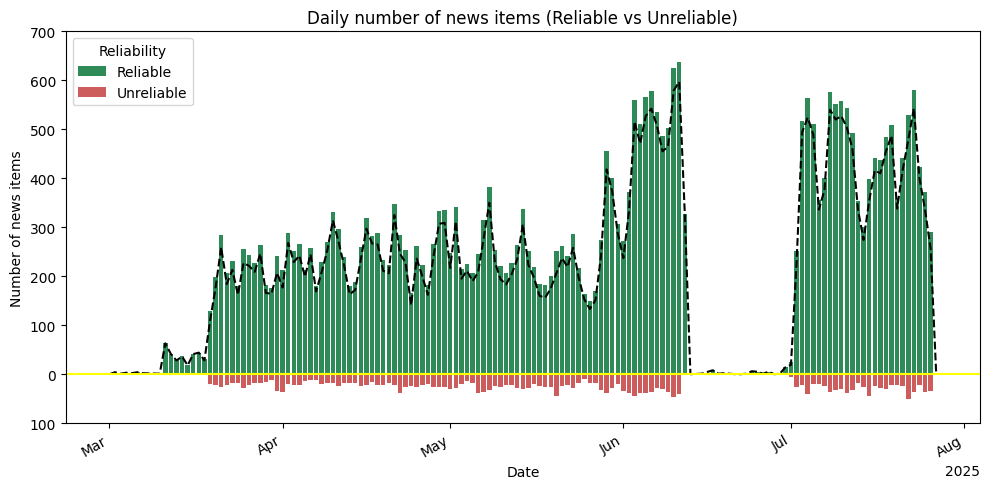

In [ ]:
plot_path = Path("news_article_counts_by_date_reliability.json")
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas().sort_values("date")
# Prepare DataFrame for plotting (treat Reliable and Unreliable as categories; exclude 'mid' by default)
df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
df_plot["Reliable_reliable"] = df_loaded_pd["reliable_count"].astype(int)
df_plot["Unreliable_unreliable"] = df_loaded_pd["unreliable_count"].astype(int)
categories = ["Reliable", "Unreliable"]
# Plot diverging bars: reliable (positive) vs unreliable (negative)
fig, ax = plt.subplots(figsize=(10, 5))
colors_map = {"Reliable": "seagreen", "Unreliable": "indianred"}
bottom_pos = np.zeros(len(df_plot))
bottom_neg = np.zeros(len(df_plot))
# Plot reliable counts above baseline
for cat in ["Reliable"]:
    rel_col = f"{cat}_reliable"
    ax.bar(df_plot["date"], df_plot[rel_col], bottom=bottom_pos, color=colors_map[cat], label=cat)
    bottom_pos += df_plot[rel_col].to_numpy()
# Plot unreliable counts below baseline
for cat in ["Unreliable"]:
    unrel_col = f"{cat}_unreliable"
    ax.bar(df_plot["date"], -df_plot[unrel_col].to_numpy(), bottom=-bottom_neg, color=colors_map[cat], label=cat)
    bottom_neg += df_plot[unrel_col].to_numpy()
# Plot difference line (Reliable – Unreliable)
diff_series = bottom_pos - bottom_neg
ax.plot(df_plot["date"], diff_series, c="k", ls="--")
ax.axhline(0, color="yellow")  # zero baseline
# Customize axes
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"))
_maybe_format_date_axis(ax, df_plot["date"])
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([int(abs(t)) for t in ax.get_yticks()])  # use absolute tick labels
ax.legend(title="Reliability")
plt.tight_layout()
plt.show()

# Optionally, include 'not_determined' in the visualization:
# To visualize the 'not_determined' counts, you could stack them on top of the reliable counts (neutral category).
# For example:
# bottom = df_plot["Reliable_reliable"].to_numpy().copy()
# ax.bar(df_plot["date"], df_loaded_pd["not_determined"], bottom=bottom, color="gray", label="Not determined")
# ax.legend(title="Reliability")
# (Including 'not_determined' will show all news items, but note that the difference line will then represent (Reliable + Not_determined) – Unreliable.)


In [ ]:
# 10. Load Language Counts JSON and Plot

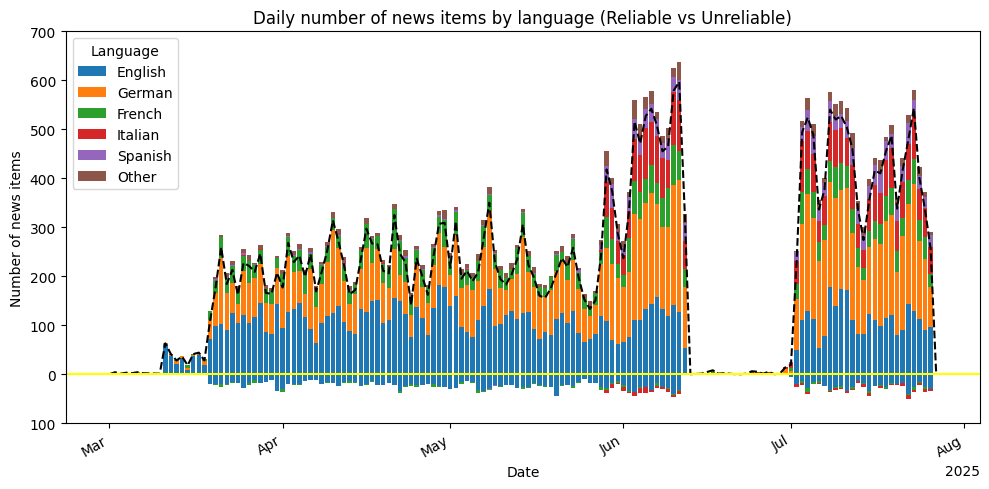

In [ ]:
plot_path = Path("news_article_counts_by_language_reliability.json")
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas().sort_values("date")
# Determine top languages by total reliable + unreliable counts (ignore 'mid' for ranking)
lang_sums_reliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_reliable")]].sum()
lang_sums_unreliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_unreliable")]].sum()
lang_sums_reliable.index = [idx.replace("_reliable", "") for idx in lang_sums_reliable.index]
lang_sums_unreliable.index = [idx.replace("_unreliable", "") for idx in lang_sums_unreliable.index]
total_extremes = lang_sums_reliable.add(lang_sums_unreliable, fill_value=0)
TOP_N = 5
if len(total_extremes) > TOP_N:
    top_langs = total_extremes.nlargest(TOP_N).index.tolist()
    other_langs = [lang for lang in total_extremes.index if lang not in top_langs]
else:
    top_langs = total_extremes.index.tolist()
    other_langs = []
# Build DataFrame for plotting (only top languages + optional "Other")
df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
for lang in top_langs:
    rel_col = f"{lang}_reliable"
    unrel_col = f"{lang}_unreliable"
    df_plot[rel_col] = df_loaded_pd.get(rel_col, 0)
    df_plot[unrel_col] = df_loaded_pd.get(unrel_col, 0)
if other_langs:
    # Aggregate remaining languages as "Other"
    other_rel_cols = [f"{lang}_reliable" for lang in other_langs if f"{lang}_reliable" in df_loaded_pd.columns]
    other_unrel_cols = [f"{lang}_unreliable" for lang in other_langs if f"{lang}_unreliable" in df_loaded_pd.columns]
    df_plot["Other_reliable"] = df_loaded_pd[other_rel_cols].sum(axis=1) if other_rel_cols else 0
    df_plot["Other_unreliable"] = df_loaded_pd[other_unrel_cols].sum(axis=1) if other_unrel_cols else 0
    categories = top_langs + ["Other"]
else:
    categories = top_langs
# Plot stacked diverging bars by language
fig, ax = plt.subplots(figsize=(10, 5))
bottom_pos = np.zeros(len(df_plot))
bottom_neg = np.zeros(len(df_plot))
color_cycle = plt.rcParams['axes.prop_cycle']()
colors_map = {cat: next(color_cycle)['color'] for cat in categories}
for cat in categories:
    rel_col = f"{cat}_reliable"
    ax.bar(df_plot["date"], df_plot[rel_col], bottom=bottom_pos, color=colors_map[cat], label=cat)
    bottom_pos += df_plot[rel_col].to_numpy()
for cat in categories:
    unrel_col = f"{cat}_unreliable"
    ax.bar(df_plot["date"], -df_plot[unrel_col].to_numpy(), bottom=-bottom_neg, color=colors_map[cat])
    bottom_neg += df_plot[unrel_col].to_numpy()
diff_series = bottom_pos - bottom_neg
ax.plot(df_plot["date"], diff_series, c="k", ls="--")
ax.axhline(0, color="yellow")
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"))
_maybe_format_date_axis(ax, df_plot["date"])
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([int(abs(t)) for t in ax.get_yticks()])
ax.legend(title="Language")
plt.tight_layout()
plt.show()

# Optionally, visualize only a selected language's reliability over time:
# available_languages = sorted({col.split('_')[0] for col in df_loaded_pd.columns if col != "date"})
# print("Available languages:", available_languages)
# selected_language = "en"  # example: choose one language code from the list
# col_rel = f"{selected_language}_reliable"; col_unrel = f"{selected_language}_unreliable"
# if col_rel in df_loaded_pd.columns and col_unrel in df_loaded_pd.columns:
#     df_single = df_loaded_pd[["date", col_rel, col_unrel]].copy().fillna(0)
#     fig, ax = plt.subplots(figsize=(10, 5))
#     ax.bar(df_single["date"], df_single[col_rel], color="seagreen", label="Reliable")
#     ax.bar(df_single["date"], -df_single[col_unrel], color="indianred", label="Unreliable")
#     diff_line = df_single[col_rel] - df_single[col_unrel]
#     ax.plot(df_single["date"], diff_line, c="k", ls="--")
#     ax.axhline(0, color="yellow")
#     ax.set_xlabel("Date")
#     ax.set_ylabel(plot_d_loaded.get("ylabel"))
#     ax.set_title(f"Daily news items ({selected_language} – Reliable vs Unreliable)")
#     _maybe_format_date_axis(ax, df_single["date"])
#     ax.legend()
#     plt.tight_layout()
#     plt.show()


In [ ]:
# 11. Load Country Counts JSON and Plot

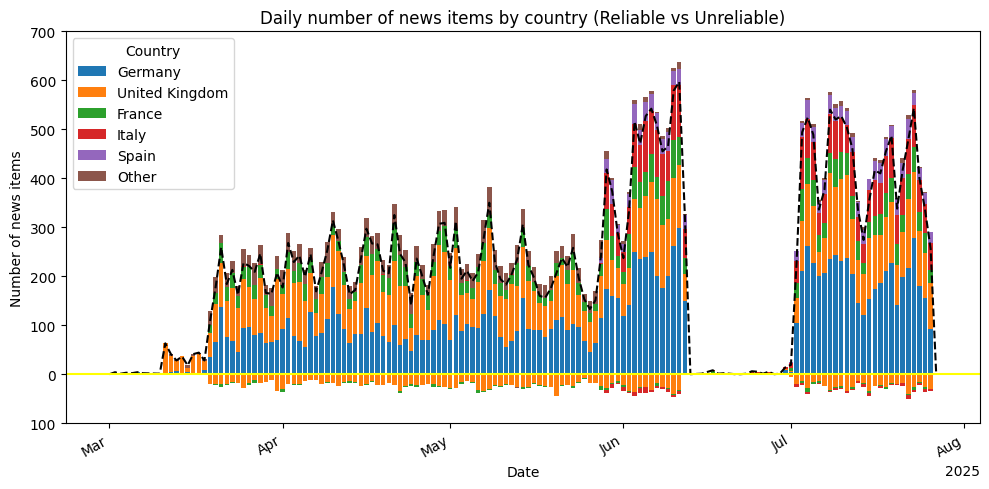

In [ ]:
plot_path = Path("news_article_counts_by_country_reliability.json")
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas().sort_values("date")
# Determine top countries by reliable + unreliable counts
country_sums_reliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_reliable")]].sum()
country_sums_unreliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_unreliable")]].sum()
country_sums_reliable.index = [idx.replace("_reliable", "") for idx in country_sums_reliable.index]
country_sums_unreliable.index = [idx.replace("_unreliable", "") for idx in country_sums_unreliable.index]
total_extremes = country_sums_reliable.add(country_sums_unreliable, fill_value=0)
TOP_N = 5
if len(total_extremes) > TOP_N:
    top_countries = total_extremes.nlargest(TOP_N).index.tolist()
    other_countries = [cty for cty in total_extremes.index if cty not in top_countries]
else:
    top_countries = total_extremes.index.tolist()
    other_countries = []
df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
for country in top_countries:
    rel_col = f"{country}_reliable"
    unrel_col = f"{country}_unreliable"
    df_plot[rel_col] = df_loaded_pd.get(rel_col, 0)
    df_plot[unrel_col] = df_loaded_pd.get(unrel_col, 0)
if other_countries:
    other_rel_cols = [f"{cty}_reliable" for cty in other_countries if f"{cty}_reliable" in df_loaded_pd.columns]
    other_unrel_cols = [f"{cty}_unreliable" for cty in other_countries if f"{cty}_unreliable" in df_loaded_pd.columns]
    df_plot["Other_reliable"] = df_loaded_pd[other_rel_cols].sum(axis=1) if other_rel_cols else 0
    df_plot["Other_unreliable"] = df_loaded_pd[other_unrel_cols].sum(axis=1) if other_unrel_cols else 0
    categories = top_countries + ["Other"]
else:
    categories = top_countries
fig, ax = plt.subplots(figsize=(10, 5))
bottom_pos = np.zeros(len(df_plot))
bottom_neg = np.zeros(len(df_plot))
color_cycle = plt.rcParams['axes.prop_cycle']()
colors_map = {cat: next(color_cycle)['color'] for cat in categories}
for cat in categories:
    rel_col = f"{cat}_reliable"
    ax.bar(df_plot["date"], df_plot[rel_col], bottom=bottom_pos, color=colors_map[cat], label=cat)
    bottom_pos += df_plot[rel_col].to_numpy()
for cat in categories:
    unrel_col = f"{cat}_unreliable"
    ax.bar(df_plot["date"], -df_plot[unrel_col].to_numpy(), bottom=-bottom_neg, color=colors_map[cat])
    bottom_neg += df_plot[unrel_col].to_numpy()
diff_series = bottom_pos - bottom_neg
ax.plot(df_plot["date"], diff_series, c="k", ls="--")
ax.axhline(0, color="yellow")
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"))
_maybe_format_date_axis(ax, df_plot["date"])
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([int(abs(t)) for t in ax.get_yticks()])
ax.legend(title="Country")
plt.tight_layout()
plt.show()

# Optionally, visualize one country:
# available_countries = sorted({col.split('_')[0] for col in df_loaded_pd.columns if col != "date"})
# print("Available countries:", available_countries)
# selected_country = "US"
# col_rel = f"{selected_country}_reliable"; col_unrel = f"{selected_country}_unreliable"
# if col_rel in df_loaded_pd.columns and col_unrel in df_loaded_pd.columns:
#     df_single = df_loaded_pd[["date", col_rel, col_unrel]].copy().fillna(0)
#     fig, ax = plt.subplots(figsize=(10, 5))
#     ax.bar(df_single["date"], df_single[col_rel], color="seagreen", label="Reliable")
#     ax.bar(df_single["date"], -df_single[col_unrel], color="indianred", label="Unreliable")
#     diff_line = df_single[col_rel] - df_single[col_unrel]
#     ax.plot(df_single["date"], diff_line, c="k", ls="--")
#     ax.axhline(0, color="yellow")
#     ax.set_xlabel("Date")
#     ax.set_ylabel(plot_d_loaded.get("ylabel"))
#     ax.set_title(f"Daily news items ({selected_country} – Reliable vs Unreliable)")
#     _maybe_format_date_axis(ax, df_single["date"])
#     ax.legend()
#     plt.tight_layout()
#     plt.show()


In [ ]:
# 12. Load Topic Counts JSON and Plot

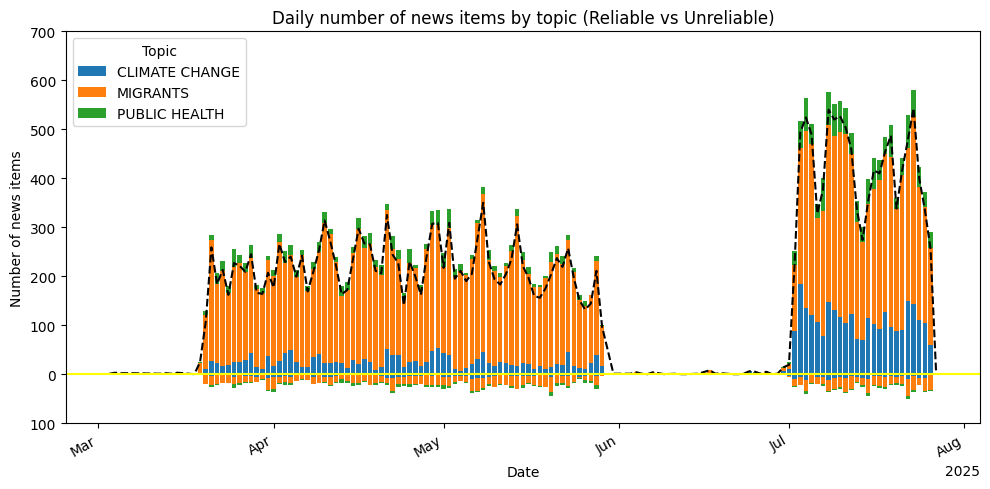

In [ ]:
plot_path = Path("news_article_counts_by_topic_reliability.json")
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas().sort_values("date")
# Determine top topics by reliable + unreliable counts
topic_sums_reliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_reliable")]].sum()
topic_sums_unreliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_unreliable")]].sum()
topic_sums_reliable.index = [idx.replace("_reliable", "") for idx in topic_sums_reliable.index]
topic_sums_unreliable.index = [idx.replace("_unreliable", "") for idx in topic_sums_unreliable.index]
total_extremes = topic_sums_reliable.add(topic_sums_unreliable, fill_value=0)
TOP_N = 10
if len(total_extremes) > TOP_N:
    top_topics = total_extremes.nlargest(TOP_N).index.tolist()
    other_topics = [tp for tp in total_extremes.index if tp not in top_topics]
else:
    top_topics = total_extremes.index.tolist()
    other_topics = []
df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
for topic in top_topics:
    rel_col = f"{topic}_reliable"
    unrel_col = f"{topic}_unreliable"
    df_plot[rel_col] = df_loaded_pd.get(rel_col, 0)
    df_plot[unrel_col] = df_loaded_pd.get(unrel_col, 0)
if other_topics:
    other_rel_cols = [f"{tp}_reliable" for tp in other_topics if f"{tp}_reliable" in df_loaded_pd.columns]
    other_unrel_cols = [f"{tp}_unreliable" for tp in other_topics if f"{tp}_unreliable" in df_loaded_pd.columns]
    df_plot["Other_reliable"] = df_loaded_pd[other_rel_cols].sum(axis=1) if other_rel_cols else 0
    df_plot["Other_unreliable"] = df_loaded_pd[other_unrel_cols].sum(axis=1) if other_unrel_cols else 0
    categories = top_topics + ["Other"]
else:
    categories = top_topics
fig, ax = plt.subplots(figsize=(10, 5))
bottom_pos = np.zeros(len(df_plot))
bottom_neg = np.zeros(len(df_plot))
color_cycle = plt.rcParams['axes.prop_cycle']()
colors_map = {cat: next(color_cycle)['color'] for cat in categories}
for cat in categories:
    rel_col = f"{cat}_reliable"
    ax.bar(df_plot["date"], df_plot[rel_col], bottom=bottom_pos, color=colors_map[cat], label=cat)
    bottom_pos += df_plot[rel_col].to_numpy()
for cat in categories:
    unrel_col = f"{cat}_unreliable"
    ax.bar(df_plot["date"], -df_plot[unrel_col].to_numpy(), bottom=-bottom_neg, color=colors_map[cat])
    bottom_neg += df_plot[unrel_col].to_numpy()
diff_series = bottom_pos - bottom_neg
ax.plot(df_plot["date"], diff_series, c="k", ls="--")
ax.axhline(0, color="yellow")
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"))
_maybe_format_date_axis(ax, df_plot["date"])
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([int(abs(t)) for t in ax.get_yticks()])
ax.legend(title="Topic")
plt.tight_layout()
plt.show()

# Optionally, visualize one topic:
# available_topics = sorted({col.split('_')[0] for col in df_loaded_pd.columns if col != "date"})
# print("Available topics:", available_topics)
# selected_topic = "Politics"
# col_rel = f"{selected_topic}_reliable"; col_unrel = f"{selected_topic}_unreliable"
# if col_rel in df_loaded_pd.columns and col_unrel in df_loaded_pd.columns:
#     df_single = df_loaded_pd[["date", col_rel, col_unrel]].copy().fillna(0)
#     fig, ax = plt.subplots(figsize=(10, 5))
#     ax.bar(df_single["date"], df_single[col_rel], color="seagreen", label="Reliable")
#     ax.bar(df_single["date"], -df_single[col_unrel], color="indianred", label="Unreliable")
#     diff_line = df_single[col_rel] - df_single[col_unrel]
#     ax.plot(df_single["date"], diff_line, c="k", ls="--")
#     ax.axhline(0, color="yellow")
#     ax.set_xlabel("Date")
#     ax.set_ylabel(plot_d_loaded.get("ylabel"))
#     ax.set_title(f"Daily news items ({selected_topic} – Reliable vs Unreliable)")
#     _maybe_format_date_axis(ax, df_single["date"])
#     ax.legend()
#     plt.tight_layout()
#     plt.show()
